# Project: Automated Loan Approval System using ML Classifier

## Made By: Siddhartha Patra

In [1]:
# Install required packages
# !pip install --upgrade Cython pandas statsmodels urllib3 joblib

In [2]:
# Install specific versions of additional packages
# !pip install fancyimpute==0.7.0
# !pip install imblearn==0.0
# !pip install joblib==1.0.1
# !pip install matplotlib==3.3.4
# !pip install numpy==1.19.5
# !pip install pandas==1.3.5
# !pip install scikit_learn==0.24.2
# !pip install scipy==1.6.2
# !pip install seaborn==0.11.1
# !pip install six==1.15.0
# !pip install xgboost==1.5.1

In [3]:
# Import necessary modules
from fancyimpute import KNN, SoftImpute

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib

%matplotlib inline


In [4]:
# Import necessary modules and perform modifications for compatibility
import operator

import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

In [5]:
# Upgrade scikit-learn and imbalanced-learn packages
!pip install --upgrade scikit-learn imbalanced-learn --user

In [6]:
# Import SMOTE from imblearn.over_sampling
from imblearn.over_sampling import SMOTE

## Defining Functions for our problem

The following functions are defined below:

* The 'classify' function fits a model, predicts probabilities, and prints various evaluation metrics. 
* The 'feat_importance' function calculates the importance of features in a model.
* The 'run_models' function compares different models, computes evaluation metrics, and plots ROC curves.

In [7]:
#Function to fit a model, predict probabilities, and print various evaluation metrics
def classify(est, x, y,X_test,y_test):
    #Passing the model and train test dataset to fit the model
    est.fit(x, y)
    
    # Predict probabilities of the test data
    y2 = est.predict_proba(X_test)
    # Predict labels of the test data
    y1 = est.predict(X_test)

    # Print accuracy, area under the ROC curve, and F-metric
    print("Accuracy: ", metrics.accuracy_score(y_test, y1))
    print("Area under the ROC curve: ", metrics.roc_auc_score(y_test, y2[:, 1]))
    print("F-metric: ", metrics.f1_score(y_test, y1))
    print(" ")
    
    # Print classification report
    print("Classification report:")
    print(metrics.classification_report(y_test, y1))
    print(" ")
    
    # Print evaluation by cross-validation
    print("Evaluation by cross-validation:")
    print(cross_val_score(est, x, y))
    
    return est, y1, y2[:, 1]


#Function to find which features are more important than others through model
def feat_importance(estimator):
    # Create an empty dictionary to store feature importance values
    feature_importance = {}
    
     # Iterate over the columns of the DataFrame (df_LC)
    for index, name in enumerate(df_LC.columns):
        # Store the feature importance value for each column
        feature_importance[name] = estimator.feature_importances_[index]

    feature_importance = {k: v for k, v in feature_importance.items()}
    # Sort the feature importance dictionary by values in descending order
    sorted_x = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse = True)
    
    # Return the sorted feature importance list
    return sorted_x

#Model to  predict the ROC curve for various models and finding the best one
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    # Define the classifiers to be evaluated
    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            #'GaussianNB': GaussianNB(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10),
            'XGBClassifier': XGBClassifier()
            }
    # Define the columns for the models report
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    # Create an empty DataFrame to store the models' evaluation report
    models_report = pd.DataFrame(columns = cols)
    # Create an empty dictionary to store the confusion matrices
    conf_matrix = dict()

    # Iterate over each classifier and evaluate its performance
    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        # Fit the classifier on the training data
        clf.fit(X_train, y_train)

        # Predict labels and probabilities for the test data
        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        # Print the progress of the current model evaluation
        print('computing {} - {} '.format(clf_name, model_type))

        # Calculate evaluation metrics
        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        # Append the model's evaluation report to the models_report DataFrame
        models_report = models_report.append(tmp, ignore_index = True)
        # Create the confusion matrix for the model
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        # Generate ROC curve for the model
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        # Plot the ROC curve for the model
        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
        
    # Plot the reference line for a random classifier
    plt.plot([0,1],[0,1], color = 'black')
    
    # Return the models' evaluation report and the confusion matrices
    return models_report, conf_matrix

In [8]:
#Importing the datasets
data =pd.read_csv("https://s3.amazonaws.com/hackerday.datascience/358/LoansTrainingSetV2.csv")

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\IPython\core\interactiveshell.py:3505: DtypeWarning: Columns (10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Exploratory Data Analysis

In [9]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [10]:
len(data)

111107

In [11]:
#Drop the duplicates with respect to LOAN ID
data.drop_duplicates(subset="Loan ID",keep='first',inplace=True)

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


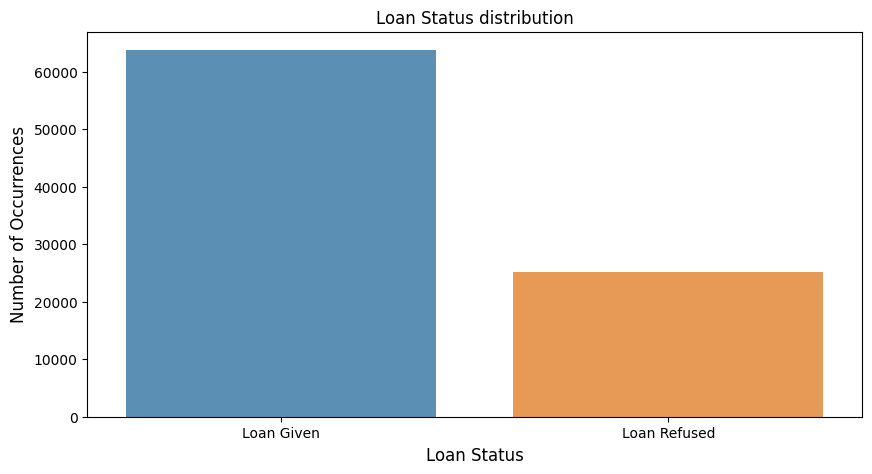

In [12]:
#PLotting the loan status 
status=data["Loan Status"].value_counts() 

plt.figure(figsize=(10,5))
sns.barplot(status.index, status.values, alpha=0.8)
plt.title('Loan Status distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Status', fontsize=12)
plt.show()

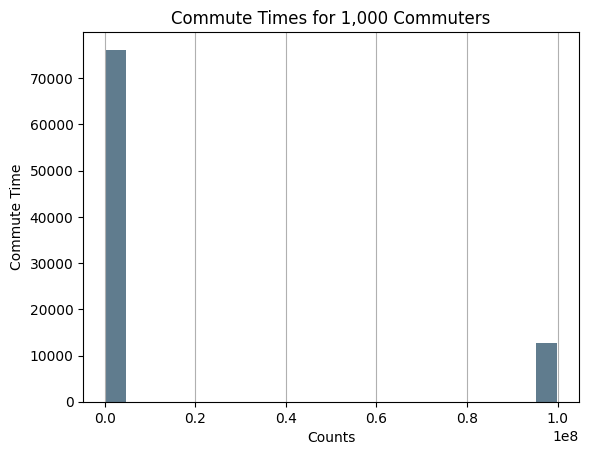

In [13]:
############ Current Loan Amount ############T

# Descriptive statistics for the "Current Loan Amount" column
data["Current Loan Amount"].describe()

# Plot a histogram of the "Current Loan Amount" column
data["Current Loan Amount"].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

In [14]:
#Finding IQR's for outlier removal

Q1 = data["Current Loan Amount"].quantile(0.25)
Q3 = data["Current Loan Amount"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

16202.0


In [15]:
# Filter the "Current Loan Amount" column based on outliers using the IQR method
data["Current Loan Amount"][((data["Current Loan Amount"] < (Q1 - 1.5 * IQR)) |(data["Current Loan Amount"] > (Q3 + 1.5 * IQR)))]

5044     99999999
5045     99999999
5046     99999999
5047     99999999
5048     99999999
           ...   
17777    99999999
17778    99999999
17779    99999999
17780    99999999
17781    99999999
Name: Current Loan Amount, Length: 12738, dtype: int64

In [16]:
# Convert the values of the "Current Loan Amount" column to a NumPy array
temp=np.array(data["Current Loan Amount"].values.tolist())

# Create a new column called "Current Loan Amount_temp" with modified values
# If a value in "Current Loan Amount" is greater than 9999998, set it to 'NaN', otherwise, keep the original value
data["Current Loan Amount_temp"] = np.where(temp > 9999998, 'NaN', temp).tolist()

count    76172.000000
mean     13933.915756
std       8235.921922
min        491.000000
25%       7810.000000
50%      12038.000000
75%      19351.000000
max      35875.000000
Name: Current Loan Amount_temp, dtype: float64

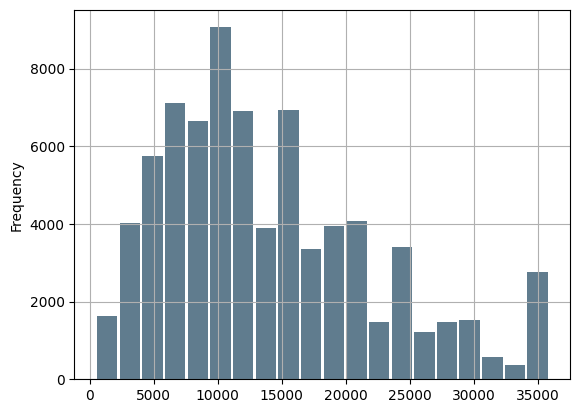

In [17]:
# Filter the "Current Loan Amount_temp" column to exclude 'NaN' values,
# convert the filtered values to integers, and assign to the 'temp' variable
temp=data["Current Loan Amount_temp"][data["Current Loan Amount_temp"]!='NaN'].astype(str).astype(int)

# Plot a histogram of the 'temp' variable
temp.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')

# Calculate and display descriptive statistics for the 'temp' variable
temp.describe()

In [18]:
#Replacing the data with 50% percentile or mean
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount"] = np.where(temp > 9999998,12038,temp).tolist()

# Drop the temporary column "Current Loan Amount_temp" from the DataFrame
data=data.drop(['Current Loan Amount_temp'],axis=1)

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


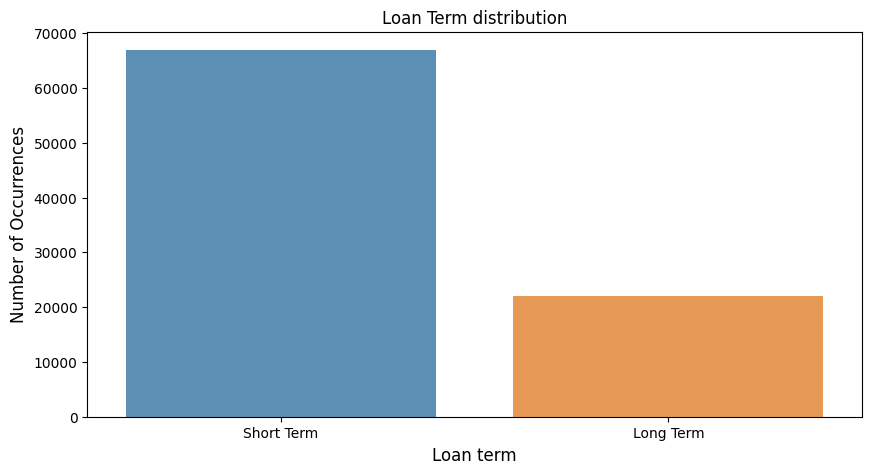

In [19]:
############ Term ##############

# Count the occurrences of each value in the "Term" column
status=data["Term"].value_counts() 

# Create a bar plot to visualize the distribution of loan terms
plt.figure(figsize=(10,5))
sns.barplot(status.index, status.values, alpha=0.8)
plt.title('Loan Term distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan term', fontsize=12)
plt.show()

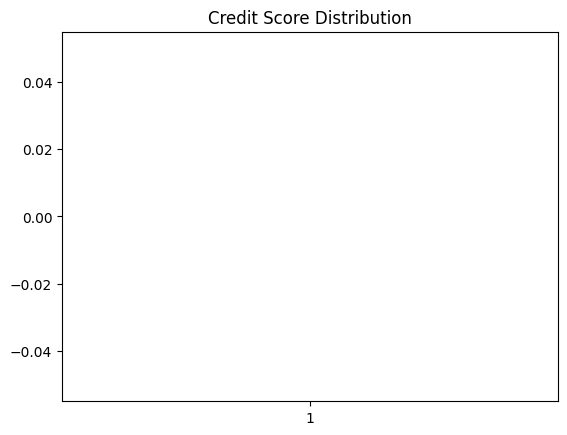

In [20]:
##### Credit Score #############

# Descriptive statistics for the "Credit Score" column
data["Credit Score"].describe()
##Max is 7510. It should be between 0-800

# Identify potential outliers by creating a boxplot of the "Credit Score" column
plt.boxplot(data["Credit Score"])

plt.title('Credit Score Distribution')
plt.show()

In [21]:
# Check the number of missing values in the "Credit Score" column
data["Credit Score"].isnull().sum()

21338

In [22]:
#Now lets do treatment of the data at hand. Let us firstly divide the values greater than 800 by 10
data["Credit Score"]=np.where(data["Credit Score"]>800, data["Credit Score"]/10, data["Credit Score"])

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Credit Score_1', ylabel='Density'>

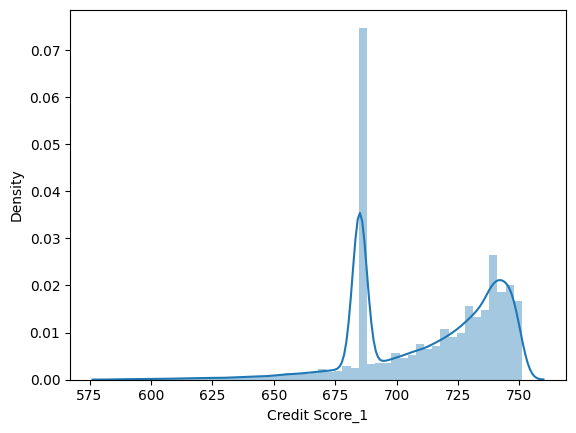

In [23]:
# Replace missing values with the median
median_score=statistics.median(data["Credit Score"])

# Create a new column "Credit Score_1" with missing values replaced by the median
data["Credit Score_1"]=data["Credit Score"]
data["Credit Score_1"].fillna(median_score, inplace = True) 

# Visualize the distribution of "Credit Score_1"
sns.distplot(data["Credit Score_1"])

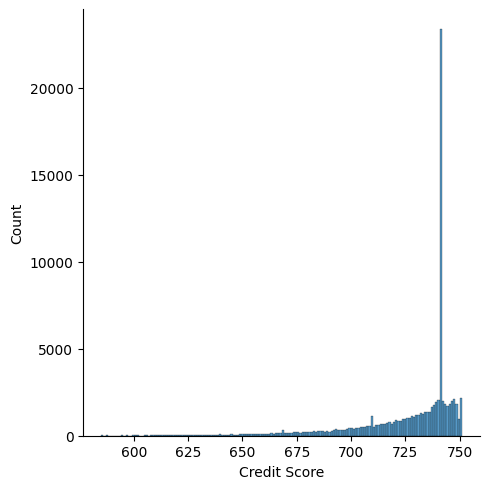

In [24]:
#As we can see this data is skewed so when we replace it with median it is giving us problems. 
#Replacing with 75th percentile and taking log we get a better distribution
data["Credit Score"].fillna(741, inplace = True) 

# Visualize the distribution of "Credit Score"
sns.displot(data["Credit Score"])

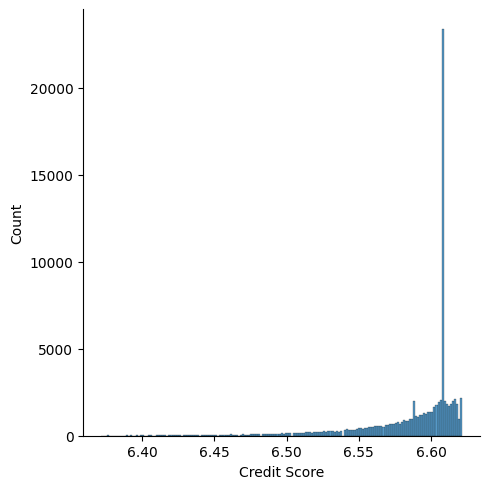

In [25]:
# Transform the "Credit Score" values using logarithm
sns.displot(np.log(data["Credit Score"]))

In [26]:
# Check for unique values in the "Home Ownership" column
data['Home Ownership'].unique()
#As we can see it has Home Mortgage and haveMortgage as 2 different classes. Lets fix that

array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)

In [27]:
# Replace 'HaveMortgage' with 'Home Mortgage' in the "Home Ownership" column
data['Home Ownership']=data['Home Ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)

# Now check for unique values in the updated "Home Ownership" column
data['Home Ownership'].unique()

array(['Rent', 'Home Mortgage', 'Own Home'], dtype=object)

In [28]:
################## Annual Income ######################
data['Annual Income'].describe()

count    6.757200e+04
mean     7.234575e+04
std      5.836101e+04
min      4.033000e+03
25%      4.458600e+04
50%      6.149400e+04
75%      8.675025e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

In [29]:
#Lets look at the quantiles of this columns
data['Annual Income'].quantile([.2,0.75,0.90,.95,0.99,.999])

0.200     40764.00
0.750     86750.25
0.900    119916.00
0.950    147645.00
0.990    239286.96
0.999    491575.77
Name: Annual Income, dtype: float64

In [30]:
#As we can see they lie in the 99th percentile of the data.Lets replace them
# Capping any values greater than 99% to 99th value
data.loc[data['Annual Income'] > 239287, 'Annual Income'] = 239287


data['Annual Income'].isna().sum()
#So we have about 21000 null values 

##We will impute the mising data with other columns towards the end

21338

In [31]:
############### Loan Purpose ###############

data['Purpose'].value_counts()
#So 'other' and 'Other' mean the same thing. Lets make it the same

Debt Consolidation      70447
Home Improvements        5206
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [32]:
data['Purpose']=data['Purpose'].str.replace('Other', 'other', regex=True)

In [33]:
####### Monthly debt ###############

# Descriptive statistics for the "Monthly Debt" column
data['Monthly Debt'].describe()
##So this is not numeric column. Lets explore

count     88910
unique    76609
top           0
freq         55
Name: Monthly Debt, dtype: object

In [34]:
data['Monthly Debt'] 
# But this should be a numeric column. So lets convert it to float

0         777.39
1         892.09
2        1244.02
3         990.94
4         503.71
          ...   
88905     567.62
88906    2508.63
88907      818.2
88908     360.17
88909     749.13
Name: Monthly Debt, Length: 88910, dtype: object

In [35]:
# pd.to_numeric(data['Monthly Debt'] )
#As we can see there is a $ symbol present. Lets replace it

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

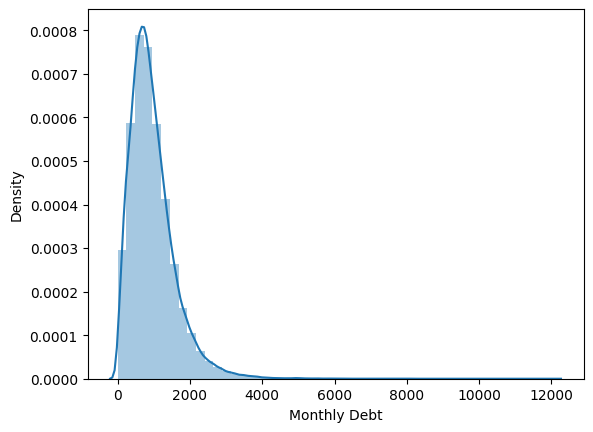

In [36]:
# Remove the dollar sign ($) from the values in the "Monthly Debt" column
data['Monthly Debt']=data['Monthly Debt'].str.replace('$', '', regex=True)

# Convert the values in the "Monthly Debt" column to numeric format
data['Monthly Debt']=pd.to_numeric(data['Monthly Debt'] )

# Visualize the distribution of "Monthly Debt"
sns.distplot(data["Monthly Debt"])

In [37]:
#We can see that there are outliers in this data because of the plot
#Lets explore Further

# Descriptive statistics for the "Monthly Debt" column
data['Monthly Debt'].describe()
#The max value is too high here

count    65536.000000
mean       962.406632
std        632.799593
min          0.000000
25%        532.250000
50%        843.770000
75%       1251.342500
max      12055.680000
Name: Monthly Debt, dtype: float64

In [38]:
#Lets look at the quantiles of this columns
data['Monthly Debt'].quantile([.2,0.75,0.90,.95,0.99,.999])

0.200     464.21000
0.750    1251.34250
0.900    1740.35000
0.950    2112.21000
0.990    3084.08600
0.999    4927.21625
Name: Monthly Debt, dtype: float64

In [39]:
#Problem is with 99th percentile. lets dig deeper

data['Monthly Debt'].quantile([0.9995,.9999])
#So problem again is wit 99th percentile

0.9995    5513.352425
0.9999    7719.187600
Name: Monthly Debt, dtype: float64

In [40]:
data['Monthly Debt'].quantile([0.9997,.99999])
#0.99970     5979.063765
#0.99999    11253.511940

0.99970     5979.063765
0.99999    11253.511940
Name: Monthly Debt, dtype: float64

In [41]:
data['Monthly Debt'].quantile([0.999,1])

0.999     4927.21625
1.000    12055.68000
Name: Monthly Debt, dtype: float64

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

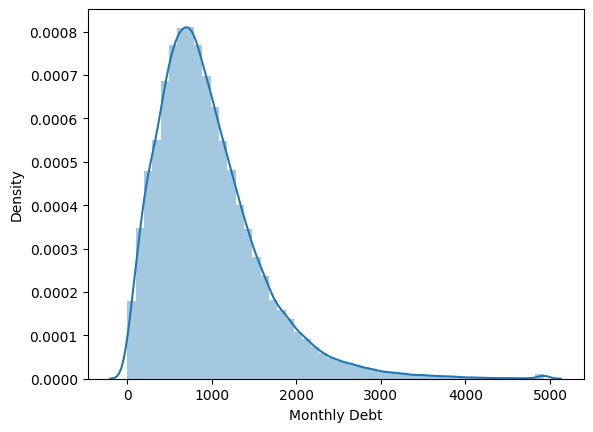

In [42]:
#Need to replace this
data.loc[data['Monthly Debt'] > 4926, 'Monthly Debt'] = 4926

sns.distplot(data["Monthly Debt"])
#Now we get the right distribution

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Years of Credit History', ylabel='Density'>

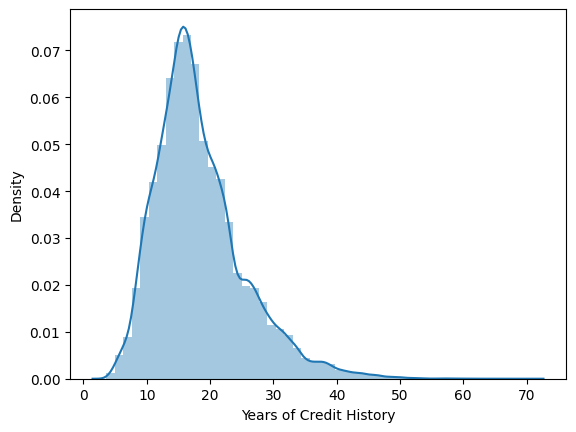

In [43]:
#################### Years of credit history #################

# Count the occurrences of each unique value in the "Years of Credit History" column
data['Years of Credit History'].value_counts()

# Visualize the distribution of "Years of Credit History"
sns.distplot(data["Years of Credit History"])
#Over all looks pretty clean! no need of doing anything

In [44]:
############# Months since last delinquent ####################

# Descriptive statistics for the "Months since last delinquent" column
data['Months since last delinquent'].describe()

count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64

In [45]:
#Lets check if there are any NA's
data['Months since last delinquent'].isna().sum()
#We have nearly 48506 NA;s. We will try to handle them at last

48506

In [46]:
############## Number of open accounts ##############

# Descriptive statistics for the "Number of Open Accounts" column
data['Number of Open Accounts'].describe()
#The max number seems odd. Lets investigate

count    88910.000000
mean        11.110348
std          4.978461
min          0.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         76.000000
Name: Number of Open Accounts, dtype: float64

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number of Open Accounts', ylabel='Density'>

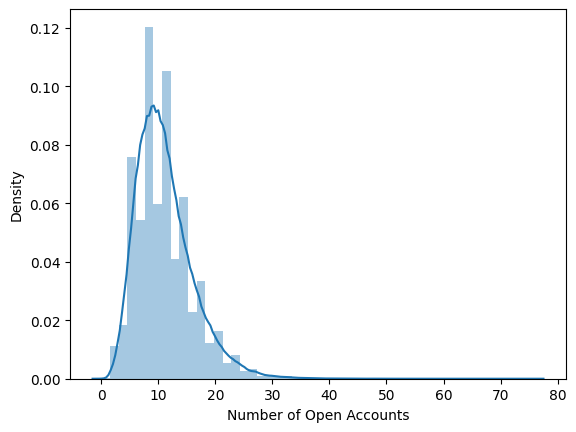

In [47]:
sns.distplot(data['Number of Open Accounts'])
#Yes there are outliers in this columns. Let dig deeper

In [48]:
data['Number of Open Accounts'].quantile([0.75,0.999,1])
#Ok so replacing anything greater than 99th percentile with 99th percentile values

0.750    14.0
0.999    36.0
1.000    76.0
Name: Number of Open Accounts, dtype: float64

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number of Open Accounts', ylabel='Density'>

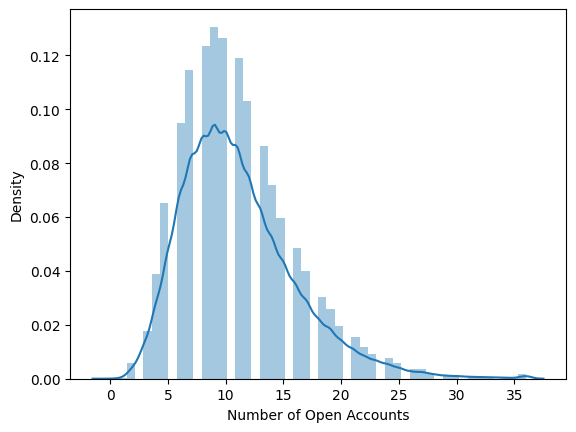

In [49]:
# Replace values greater than 36 in the "Number of Open Accounts" column with 36
data.loc[data['Number of Open Accounts'] > 36, 'Number of Open Accounts'] = 36

# Visualize the distribution of "Number of Open Accounts"
sns.distplot(data['Number of Open Accounts'])
#Looks good now

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number of Credit Problems', ylabel='Density'>

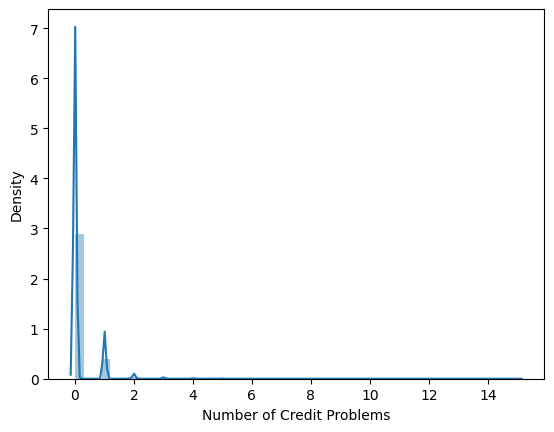

In [50]:
####################### Number of Credit problems ##############

# Descriptive statistics for the "Number of Credit Problems" column
data['Number of Credit Problems'].describe() 
#Max looks a bit higher. Lets see

sns.distplot(data['Number of Credit Problems'])

In [51]:
#Okay lets look at value _counts
data['Number of Credit Problems'].value_counts()

#Okay looks good

0     77057
1     10271
2      1092
3       311
4       101
5        46
6        14
7         6
9         4
10        3
8         2
12        1
15        1
11        1
Name: Number of Credit Problems, dtype: int64

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

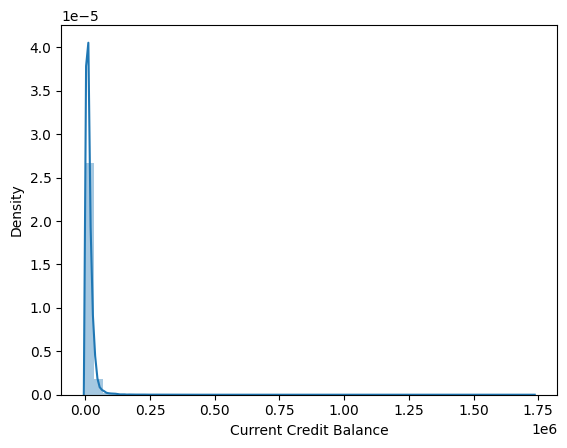

In [52]:
################## Current Credit Balance ###########

# Descriptive statistics for the "Current Credit Balance" column
data['Current Credit Balance'].describe()

sns.distplot(data['Current Credit Balance'])
#It seems there are outliers in this data. Lets investigate

In [53]:
data['Current Credit Balance'].quantile([0.75,0.95,0.999,1])

0.750      19301.000
0.950      39933.300
0.999     227670.033
1.000    1730472.000
Name: Current Credit Balance, dtype: float64

In [54]:
#lets dig deeper
data['Current Credit Balance'].quantile([0.95,0.96,0.97,0.98,0.99,1])

0.95      39933.30
0.96      43501.20
0.97      48507.73
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

In [55]:
#So lets replace it with 95th percentile
data['Current Credit Balance'].quantile([0.55,0.76,0.87,0.98,0.99,1])

0.55      12295.00
0.76      19805.84
0.87      27525.66
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

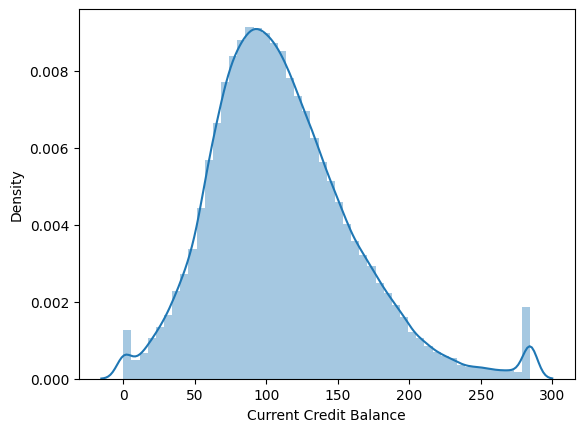

In [56]:
# Replace values greater than 81007 in the "Current Credit Balance" column with 81007
data.loc[data['Current Credit Balance'] > 81007, 'Current Credit Balance'] = 81007

# Visualize the distribution of the square root of "Current Credit Balance"
sns.distplot(data['Current Credit Balance']**(1/2))
#The plot doesnt look good. We need to transform it

In [57]:
# Apply the square root transformation to the "Current Credit Balance" column
data['Current Credit Balance']=data['Current Credit Balance']**(1/2)

In [58]:
####################### Max open credit ################

# Descriptive statistics for the "Maximum Open Credit" column
data['Maximum Open Credit'].describe()

count     88910
unique    58216
top           0
freq        450
Name: Maximum Open Credit, dtype: object

In [59]:
# Count the occurrences of each unique value in the "Maximum Open Credit" column
data['Maximum Open Credit'].value_counts()

0         450
0         160
15847       9
17464       9
6827        8
         ... 
28296       1
10199       1
132602      1
10395       1
21124       1
Name: Maximum Open Credit, Length: 58216, dtype: int64

In [60]:
# sns.distplot(data['Maximum Open Credit'])
#So there are some str characters present in the data. Lets find them
#could not convert string to float: '#VALUE!'

In [61]:
# pd.to_numeric(data['Maximum Open Credit'])
#Unable to parse string "#VALUE!" at position 4930

In [62]:
#Lets replace #value with Nan
data['Maximum Open Credit']=data['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)

In [63]:
data['Maximum Open Credit']=pd.to_numeric(data['Maximum Open Credit'])

In [64]:
data['Maximum Open Credit'].isnull().sum()
#Now we have only 2 Nan;s in the data. Lets replace them with mean  

2

In [65]:
# Replace 'nan' with mean value of '35965'
data['Maximum Open Credit']=data['Maximum Open Credit'].fillna(35965)

In [66]:
data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])

0.55       24037.95
0.76       37259.84
0.87       50736.66
0.98      114682.56
0.99      171423.91
1.00    69988086.00
Name: Maximum Open Credit, dtype: float64

In [67]:
#Lets replace the outliers
data.loc[data['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423

In [68]:
############### Bankruptcies ##########

# Descriptive statistics for the "Bankruptcies" column
data['Bankruptcies'].describe()

count    88718.000000
mean         0.112672
std          0.343300
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: Bankruptcies, dtype: float64

In [69]:
# Count the occurrences of each unique value in the "Bankruptcies" column
data['Bankruptcies'].value_counts()

0.0    79323
1.0     8936
2.0      353
3.0       80
4.0       19
5.0        5
7.0        1
6.0        1
Name: Bankruptcies, dtype: int64

In [70]:
# Retrieve unique values in the "Bankruptcies" column
data['Bankruptcies'].unique()

#So we have Nan's. Lets fill them with median

array([ 0.,  1., nan,  2.,  4.,  3.,  5.,  7.,  6.])

In [71]:
# Replacing 'nan' with median value '3'
data['Bankruptcies']=data['Bankruptcies'].fillna(3)

In [72]:
#### Tax Liens ######

# Descriptive statistics for the "Tax Liens" column
data['Tax Liens'].describe()

count    88902.000000
mean         0.028222
std          0.257533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Tax Liens, dtype: float64

In [73]:
# Count the occurrences of each unique value in the "Tax Liens" column
data['Tax Liens'].value_counts()

0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
10.0        1
11.0        1
Name: Tax Liens, dtype: int64

In [74]:
# Retrieve unique values in the "Tax Liens" column
data['Tax Liens'].unique()

#So we have Nan's. Lets fill them with median

array([ 0.,  5.,  2.,  1.,  3.,  7.,  6.,  4.,  9., nan,  8., 15., 10.,
       11.])

In [75]:
# Replacing 'nan' with median value '0'
data['Tax Liens']=data['Tax Liens'].fillna(0.0)

In [76]:
cat_cols = ['Term','Years in current job','Home Ownership','Purpose']

# Iterate over the categorical columns
for c in cat_cols:
    # Apply factorization to convert categorical values to numeric labels
    data[c] = pd.factorize(data[c])[0]

In [77]:
#Imputing missing data with soft impute
updated_data=pd.DataFrame(data=SoftImpute().fit_transform(data[data.columns[3:19]],), columns=data[data.columns[3:19]].columns, index=data.index)

#Getting the dataset ready pd.get dummies function for dropping the dummy variables
df_LC = pd.get_dummies(updated_data, drop_first=True)

[SoftImpute] Max Singular Value of X_init = 23092221.868378
[SoftImpute] Iter 1: observed MAE=261.478579 rank=3
[SoftImpute] Iter 2: observed MAE=258.546913 rank=3
[SoftImpute] Iter 3: observed MAE=258.206109 rank=3
[SoftImpute] Iter 4: observed MAE=258.183299 rank=3
[SoftImpute] Iter 5: observed MAE=258.203090 rank=3
[SoftImpute] Iter 6: observed MAE=258.228515 rank=3
[SoftImpute] Iter 7: observed MAE=258.254018 rank=3
[SoftImpute] Iter 8: observed MAE=258.278552 rank=3
[SoftImpute] Iter 9: observed MAE=258.301894 rank=3
[SoftImpute] Iter 10: observed MAE=258.323949 rank=3
[SoftImpute] Iter 11: observed MAE=258.344659 rank=3
[SoftImpute] Iter 12: observed MAE=258.363954 rank=3
[SoftImpute] Iter 13: observed MAE=258.381962 rank=3
[SoftImpute] Iter 14: observed MAE=258.398665 rank=3
[SoftImpute] Iter 15: observed MAE=258.414090 rank=3
[SoftImpute] Iter 16: observed MAE=258.428343 rank=3
[SoftImpute] Iter 17: observed MAE=258.441579 rank=3
[SoftImpute] Iter 18: observed MAE=258.453766 ra

In [78]:
#Binarizing the Target variable
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(data['Loan Status'])
y=lb_results
y=y.ravel()


#Scaling the independent variables
X_scaled = preprocessing.scale(df_LC)
print(X_scaled)
print('   ')
print(X_scaled.shape)

[[-0.1869176  -0.57302977  0.06886311 ... -0.79845518 -0.32295035
  -0.10958203]
 [ 1.48349848  1.74511004  0.26644983 ...  1.83825771 -0.32295035
  -0.10958203]
 [ 0.32079375 -0.57302977 -0.08920626 ... -0.53977375  2.39304617
  -0.10958203]
 ...
 [ 1.40247376 -0.57302977  0.78017528 ...  0.91232955 -0.32295035
  -0.10958203]
 [-1.1281112  -0.57302977 -0.16824094 ... -0.4039368  -0.32295035
  -0.10958203]
 [ 0.62515919 -0.57302977 -0.32631031 ... -0.30218149 -0.32295035
   3.77361392]]
   
(88910, 16)


## ML Model - Prediction, Evaluation & Feauture Importance

In [79]:
#Looking at other models using different classifiers
# Splitting the scaled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=22)

[18:06:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy:  0.7276646796385858
Area under the ROC curve:  0.7437786371367399
F-metric:  0.38419803323160395
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83     18981
           1       0.55      0.29      0.38      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.60      0.60     26673
weighted avg       0.70      0.73      0.70     26673

 
Evaluation by cross-validation:
[18:06:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.73088046 0.73762853 0.73150157 0.73150157 0.72740419]
[0.15770203 0.25137326 0.16299245 0.02831689 0.04490009 0.04055737
 0.03080421 0.03046158 0.02761248 0.02706706 0.02785725 0.02524857
 0.03073877 0.03578309 0.03659303 0.0419918 ]


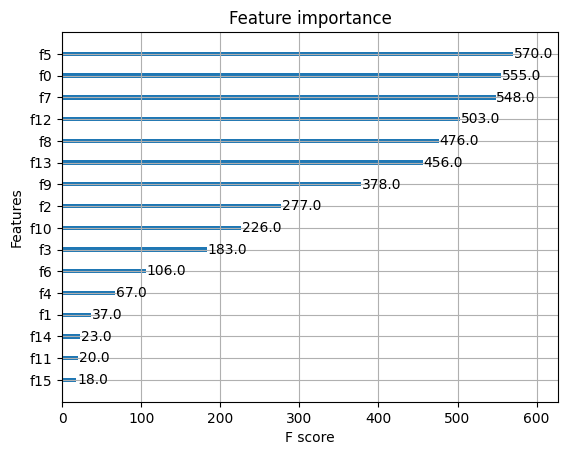

In [80]:
#Finding accuracy and feature importance using XGB classifier
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(), X_train, y_train,X_test,y_test)

# Printing the feature importances
print(xgb0.feature_importances_)

# Plotting the feature importances
plot_importance(xgb0)
pyplot.show()

# Obtaining the sorted feature importances
feat1 = feat_importance(xgb0)

In [81]:
# Finding accuracy and feature importance using XGB classifier with customized parameters
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(n_estimators=47, learning_rate=0.015), X_train, y_train,X_test,y_test)

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.7290893412814456
Area under the ROC curve:  0.7381679994031858
F-metric:  0.3351122561648877
 
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83     18981
           1       0.57      0.24      0.34      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.58      0.58     26673
weighted avg       0.70      0.73      0.69     26673

 
Evaluation by cross-validation:
[18:06:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logisti

F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.73666452 0.74116324 0.73608098 0.73664337 0.73013578]


In [82]:
####### K nearest Neighbour classifier ################

# Finding accuracy using KNeighborsClassifier
knc, y_p, y_p2 = classify(KNeighborsClassifier(), X_train, y_train,X_test,y_test)

Accuracy:  0.6839500618603082
Area under the ROC curve:  0.6073078340129547
F-metric:  0.30992141453831046
 
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80     18981
           1       0.42      0.25      0.31      7692

    accuracy                           0.68     26673
   macro avg       0.58      0.55      0.55     26673
weighted avg       0.65      0.68      0.66     26673

 
Evaluation by cross-validation:
[0.69368573 0.69705977 0.69783884 0.69141159 0.68747489]


In [83]:
######## Logistic Regression ##############

# Finding accuracy using Logistic Regression
logit, y_p, y_p2 = classify(LogisticRegression(), X_train, y_train,X_test,y_test)

Accuracy:  0.7201289693697747
Area under the ROC curve:  0.6722708695503397
F-metric:  0.21213720316622697
 
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83     18981
           1       0.56      0.13      0.21      7692

    accuracy                           0.72     26673
   macro avg       0.65      0.54      0.52     26673
weighted avg       0.68      0.72      0.65     26673

 
Evaluation by cross-validation:
[0.72606041 0.72919344 0.72812726 0.7282076  0.72684181]


In [84]:
######## Decision Tree Classifier ##########

# Finding accuracy using Decision Tree Classifier
dtc, y_p, y_p2 = classify(DecisionTreeClassifier(), X_train, y_train,X_test,y_test)

Accuracy:  0.651932665991827
Area under the ROC curve:  0.5798438022553303
F-metric:  0.4042607802874743
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75     18981
           1       0.40      0.41      0.40      7692

    accuracy                           0.65     26673
   macro avg       0.58      0.58      0.58     26673
weighted avg       0.65      0.65      0.65     26673

 
Evaluation by cross-validation:
[0.65351864 0.65890103 0.65710613 0.65598136 0.65067888]


computing GradientBoosting - Non-balanced 
computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 
[18:06:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


computing XGBClassifier - Non-balanced 
                    model  matthews_corrcoef  roc_auc_score  precision_score  \
0        GradientBoosting           0.244542       0.753575         0.574260   
1      LogisticRegression           0.158180       0.672406         0.554031   
2  RandomForestClassifier           0.188414       0.695860         0.499308   
3           XGBClassifier           0.245700       0.743843         0.547578   

   recall_score  f1_score    model_type  
0      0.255698  0.353842  Non-balanced  
1      0.127651  0.207495  Non-balanced  
2      0.237782  0.322149  Non-balanced  
3      0.290344  0.379477  Non-balanced  


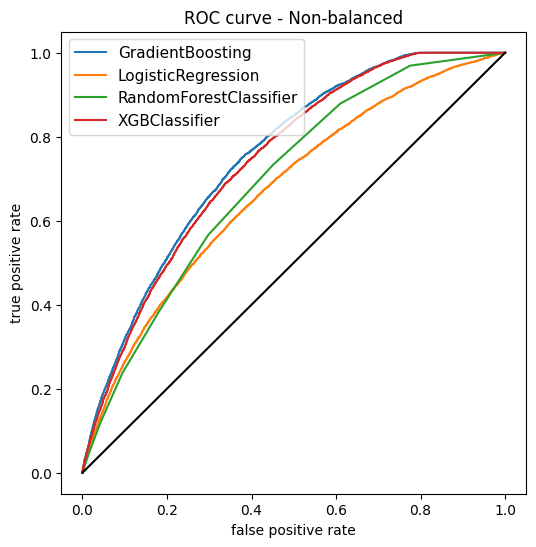

In [85]:
# Splitting the scaled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

# Running models and generating a report
models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')

# Printing the models report
print(models_report)

computing GradientBoosting - Balanced 
computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 
[18:07:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F:\Anaconda\envs\LoanEligibility_py3_8\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


computing XGBClassifier - Balanced 


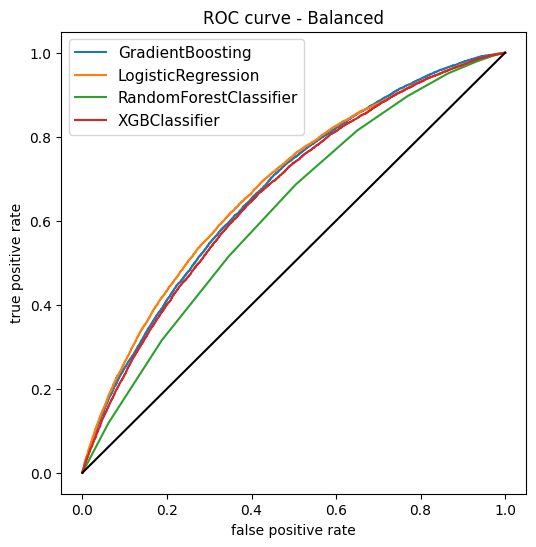

In [86]:
########### Synthetically balancing the dataset ##################

# Splitting the dataset and applying SMOTE for synthetic balancing
index_split = int(len(X_scaled)/2)
X_train, y_train = SMOTE().fit_resample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]

# Running models on the balanced dataset and generating a report
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')

In [87]:
# Now we  know that GBM model performed the best
# Hence, we will save the GBM model
gbm=GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3)
gbm.fit(X_scaled, y)
joblib.dump(gbm, 'GBM_Model_version1.pkl')
#load model
#gbm_pickle = joblib.load('GBM_Model_version1.pkl')

['GBM_Model_version1.pkl']